# Кейс А11, 2 часть (11.4.1)

### Содержание: <a name='contents'/>
 - [Исходные параметры, цели и задачи](#task)
 - [Знакомство с данными](#describe_data)
 - [Продолжаем изучать данные](#data_investigation_cont)
 - [Расчёт показателей юнит-экономики](#unit_economy)
 - [Статистическая значимость результатов](#statsign)
 - [Общие выводы по исследованию](#closure)

Исходные параметры: <a name='task'></a>

- Два лендинга, короткий и подробный
- В эксперименте участвуют все посетители, пришедшие с этих лендингов
- Вопросы:
  * С какого лендинга приходит больше пользователей?
  * Какое качество (в деньгах) этих пользователей?
  
- Платформа — облачное хранилище
- Тарифные планы (в рублях):
  + Условно-безлимитные:
    * 2 ТБ в месяц за 350,
    * 3 месяца 700,
    * год — 1500,
  + Пакет:
    * 10 ГБ за год — 50.
    
Примечание: не все регистрации происходят после посещения лендинга, один пользователь может совершить больше одной покупки. 

| [К оглавлению](#contents)   |
|:--------------------------

## Имеющиеся данные: <a name='describe_data'/>

Файлы с данными:

 - [ab_test_cookies](#ab_test_cookies)
 - [registrations_in_test_period](#registrations_in_test_period)
 - [purchases_in_test_period](#purchases_in_test_period)

In [1]:
# Импорт необходимых библиотек

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from scipy import stats as spstats
from statsmodels.stats.weightstats import ztest

# Определение констант
S3_PREFIX='https://miscelanneous.s3-eu-west-1.amazonaws.com/SkillFactory/SDA5_CaseA11'

# Инициализация графических библиотек
sns.set()
sns.set_style('whitegrid')

### ab_test_cookies

1. `cookie_id` — куки.
2. `grp` — группа, в которую входит пользователь.

In [2]:
abt_cookies_df = pd.read_csv(f"{S3_PREFIX}/ab_test_cookies.csv.bz2")
print("Строк: {}, колонок: {}".format(abt_cookies_df.shape[0], abt_cookies_df.shape[1]))
abt_cookies_df.head(3)

Строк: 253172, колонок: 2


,cookie_id,grp
0,65hj0vyf6kfrckx,A
1,dnjw8oy95td2jqf,B
2,beiyb0xfie92m43,B


| [К оглавлению](#contents) | [К началу раздела](#describe_data) |
|:--------------------------|-----------------------------------:|

### registrations_in_test_period

1. `cookie_id` — куки (см. файл #ab_test_cookies);
2. `user_id` — ID пользователя (см. в таблицу `purchases_in_test_period`).

In [3]:
reg_df = pd.read_csv(f"{S3_PREFIX}/registrations_in_test_period.csv.bz2")
print(f"Строк в таблице регистрации: {reg_df.shape[0]}")
reg_df.head(3)

Строк в таблице регистрации: 172350


,cookie_id,user_id
0,NaN,382603
1,NaN,295154
2,NaN,999732


Сразу начинаются интересности: не для всех пользователей есть куки.

| [К оглавлению](#contents) | [К началу раздела](#describe_data) |
|:--------------------------|-----------------------------------:|

###  purchases_in_test_period

1. `purchase_id` — ID покупки,
2. `user_id` — ID покупателя (см. `registrations_in_test_period`),
3. `amount` — сумма покупки в рублях.

In [4]:
purch_df = pd.read_csv(f"{S3_PREFIX}/purchases_in_test_period.csv.bz2")
print(f"Количество покупок: {purch_df.shape[0]}")
purch_df.head(3)

Количество покупок: 35147


,purchase_id,user_id,amount
0,1,275851,350
1,2,923077,1500
2,3,959409,50


| [К оглавлению](#contents) | [К началу раздела](#describe_data) |
|:--------------------------|-----------------------------------:|

## Продолжаем изучать данные <a name='data_investigation_cont'/>

### Вопросы

1. Все ли Cookie ID из файла `ab_test_cookies` есть в файле registrations?
2. Для всех ли пользователей тестовых групп есть покупки? Если нет, каковы конверсии?
3. Тарифных планов для пользователей у нас нет, придётся оценивать покупки только по суммарным показателям.
Хотя может оказаться, что по сумме будет понятно, что именно куплено.
4. Можно ли установить взаимно-однозначное соответствие между `user_id` и `cookie_id`?

Имеем последовательность действий: 

1) браузеры устанавливают соединение с сервером клиента, получают уникальные куки и с этого момента становятся «посетителями».  

2) Часть посетителей принимает решение зарегистрироваться на сервисе и превращаются в «пользователей».

3) Некоторые пользователи подключают платные услуги и становятся «покупателями».  Налицо *двухступенчатая воронка продаж*.

In [5]:
# Начинаю с подсчёта куки по группам и конверсии этих куки (назову их "посетителями") в пользователей.
ab_grps_cnt = abt_cookies_df.groupby('grp').count().rename(columns={'cookie_id': 'n_cookies'})
ab_grps_cnt['cookies_share'] = ab_grps_cnt.n_cookies / ab_grps_cnt.n_cookies.sum()
print("# of unique cookies: {0} of {1} total".format(abt_cookies_df.cookie_id.nunique(), abt_cookies_df.shape[0]))
display(ab_grps_cnt)


# of unique cookies: 253172 of 253172 total


,n_cookies,cookies_share
grp,,
A,101329,0.400238
B,151843,0.599762


Имеем дело с разделением на контрольную и экспериментальную группу в пропорции 40/60.  Вот только не известно, какая из групп контрольная.

Соотношение пользователей групп A и B не 50/50, это не лучший вариант с точки зрения планирования эксперимента и обработки его результатов. Частично это можно сгладить учётом только относительных параметров (т.е. делённых на количество пользователелей — конверсии, ARPU, ...)

Далее получим списки идентификаторов зарегистрированных пользователей в группах A и B.  По условиям работы «облачного» хранилища услуги предоставляются исключительно зарегистрированным пользователям, поэтому прямого перехода от получения куки к продажам быть не может.

In [6]:
if reg_df.user_id.nunique() == reg_df.shape[0]:
    print("Все пользователи в таблице reg_df уникальны")
sort_df = reg_df.merge(abt_cookies_df, on='cookie_id')
print(f"Всего зарегистрировалось {sort_df.shape[0]} пользователей")
a_users_st = frozenset(sort_df.loc[sort_df.grp=='A', 'user_id'])
b_users_st = frozenset(sort_df.loc[sort_df.grp=='B', 'user_id'])
print("Пользователей в группах A: {0}, B: {1}, доля группы A {2:.2%}".format(
    len(a_users_st), len(b_users_st), len(a_users_st)/(len(a_users_st) + len(b_users_st))
))

Все пользователи в таблице reg_df уникальны
Всего зарегистрировалось 72485 пользователей
Пользователей в группах A: 31439, B: 41046, доля группы A 43.37%


| [К оглавлению](#contents) | [К началу раздела](#data_investigation_cont) |
|:--------------------------|---------------------------------------------:|

 ## Расчёт показателей юнит-экономики <a name='unit_economy'/>

### Конверсия посетителей в пользователей <a name="conversion_vu"/>

Известно количество куки и зарегистрированных пользователей: можно расчитать конверсию на первом этапе.

In [7]:
ab_users_cnt = sort_df.groupby('grp')['user_id'].count()

ab_grps_cnt['n_users'] = ab_users_cnt
ab_grps_cnt['users_share'] = ab_grps_cnt.n_users / ab_grps_cnt.n_users.sum()
ab_grps_cnt['conv_v_u'] = ab_grps_cnt.n_users / ab_grps_cnt.n_cookies

display(ab_grps_cnt)
print("Итак, конверсия посетителей в пользователей для группы A составляет {0:.2%}, а для группы B {1:.2%}".format(
    ab_grps_cnt.loc['A', 'conv_v_u'], ab_grps_cnt.loc['B', 'conv_v_u']
))

,n_cookies,cookies_share,n_users,users_share,conv_v_u
grp,,,,,
A,101329,0.400238,31439,0.433731,0.310267
B,151843,0.599762,41046,0.566269,0.270319


Итак, конверсия посетителей в пользователей для группы A составляет 31.03%, а для группы B 27.03%


На этом этапе воронки никаких денег ещё нет, а данными о поведении пользователей мы не располагаем.
Перейдём к следующему этапу воронки: продаже тарифного плана.

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

### Параметры юнит-экономики на втором этапе воронки <a name='ue_2nd_conversion'/>

- [Конверсия](#conversion_uc)
- [ARPC](#arpc)
- [ARPU](#arpu)
- [Средний чек](#avg_cheque)
- [Структура покупок](#demand_structure)
- [Сводные данные по группам](#groups_ue_summary)

#### Конверсия пользователей в покупателей <a name='conversion_uc'/>

Данные по второму этапу воронки лежат в датафрейме `purch_df`. Нас интересуют те строки этого датафрейма, идентификатор которых содержится в датафрейме `reg_df`, а куки в таблице `abt_cookies_df`.  Нужно также установить, есть ли среди покупателей повторники, то есть рецидивисты:

In [8]:
print(f"Количество покупателей: {purch_df.user_id.nunique()}, кол-во покупок: {purch_df.shape[0]}")

Количество покупателей: 33740, кол-во покупок: 35147


Есть такие покупатели, которые платили деньги больше одного раза.

In [9]:
a_grp_mask = purch_df.user_id.apply(lambda x : x in a_users_st)
b_grp_mask = purch_df.user_id.apply(lambda x : x in b_users_st)
# Ловушка ошибок, чтобы убедиться, что булевы маски правильной длины
assert(len(a_grp_mask) == len(b_grp_mask))
assert(len(a_grp_mask) == purch_df.shape[0])
# Небольшой хак, основанный на том, что при суммировании True считается за 1, а False 0.
a_trn_cnt, b_trn_cnt = (a_grp_mask.sum(), b_grp_mask.sum())
transactions_count = a_trn_cnt + b_trn_cnt
print("""
Всего участники эксперимента совершили {0}  покупок, 
из них группа А : {1} ({3:.2%}),
и группа B : {2} ({4:.2%}),
""".format(
    transactions_count,
    a_trn_cnt, b_trn_cnt,
    a_trn_cnt/transactions_count, 
    b_trn_cnt/transactions_count,
))


Всего участники эксперимента совершили 15187  покупок, 
из них группа А : 6085 (40.07%),
и группа B : 9102 (59.93%),



Для расчёта конверсии нужно выделить количество уникальных покупателей в группах А и B, а количество посетителей в них мы уже знаем, оно есть в датафрейме `ab_grps_cnt`.

In [10]:
all_buyers_st = frozenset(purch_df.user_id)
a_buyers_st = all_buyers_st.intersection(a_users_st)
b_buyers_st = all_buyers_st.intersection(b_users_st)
print(f"Количество покупателей по группам: A: {len(a_buyers_st)}, B: {len(b_buyers_st)}")
conversion_v_c = {'A': float(len(a_buyers_st)) / ab_grps_cnt.loc['A', 'n_cookies'],
                  'B': float(len(b_buyers_st)) / ab_grps_cnt.loc['B', 'n_cookies']}
print("""Конверсия посетителей в покупателей по группам:
A: {0:.2%},
B: {1:.2%}.
""".format(
    conversion_v_c['A'],
    conversion_v_c['B']
))

Количество покупателей по группам: A: 5815, B: 8797
Конверсия посетителей в покупателей по группам:
A: 5.74%,
B: 5.79%.



##### Вывод по сквозной конверсии
В группе B конверсия заметно выше.  Насколько этот вывод статистически значим, посмотрим [ниже]

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

#### ARPC <a name='arpc'/>

ARPC (правильнее, общий доход на покупателя, gross revenue per customer) можно посчитать тут же, просуммировав стоимость покупок по группам.

In [11]:
print("""Доход на покупателя (ARPC) по группам:
Группа А: {0:.2f} руб.,
Группа B: {1:.2f} руб.
""".format(
purch_df.loc[a_grp_mask, 'amount'].sum() / purch_df.loc[a_grp_mask,'user_id'].nunique(),
purch_df.loc[b_grp_mask, 'amount'].sum() / purch_df.loc[b_grp_mask,'user_id'].nunique()
))

Доход на покупателя (ARPC) по группам:
Группа А: 553.05 руб.,
Группа B: 623.09 руб.



##### Вывод по ARPC:
в группе B доход на каждого покупателя заметно выше.

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

#### ARPU <a name='arpu'/>

Зная суммарный «грязный» доход в обеих группах и общее количество пользователей и посетителей, легко посчитать ARPU простым делением.  Обращаю внимание, что это ARPU может быть рассчитан двумя способами: только по зарегистрированным пользователям или по всем посетителям лендингов.  Поставленная задача относится к эффективности лендингов, поэтому ARPU я расчитываю для *посетителей*, то есть сквозное для двухэтапной воронки.

In [12]:
# этот дата-фрейм появился у нас при обработке файла ab_test_cookies
# display(ab_grps_cnt)

print("""Доход на поcетителя (ARPU) по группам:
Группа А: {0:.2f} руб.,
Группа B: {1:.2f} руб.
""".format(
purch_df.loc[a_grp_mask, 'amount'].sum() / ab_grps_cnt.loc['A', 'n_cookies'],
purch_df.loc[b_grp_mask, 'amount'].sum() / ab_grps_cnt.loc['B', 'n_cookies']
))

Доход на поcетителя (ARPU) по группам:
Группа А: 31.74 руб.,
Группа B: 36.10 руб.



##### Вывод по ARPU:
Средний доход на пользователя заметно (примерно на 1/8) выше в группе B.
Насколько значимо это изменение, посмотрим [далее](#statsign).

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

#### Средний чек (на покупку) <a name='avg_cheque'/>

Для получения среднего чека нужно разделить общую выручку в группе на количество покупок, совершённых пользователями этой группы.

Все необходимые данные уже есть в датафрейме `purch_struct_df`, осталось выполнить пару арифметических
действий.

In [13]:
# Эти переменные определены выше, когда считали покупки
# a_grp_mask = purch_df.user_id.apply(lambda x : x in a_users_st)
# b_grp_mask = purch_df.user_id.apply(lambda x : x in b_users_st)
a_avp = (purch_df.loc[a_grp_mask,'amount'].sum() / 
         purch_df.loc[a_grp_mask,'purchase_id'].count())
b_avp = (purch_df.loc[b_grp_mask,'amount'].sum() / 
         purch_df.loc[b_grp_mask,'purchase_id'].count())
print("""Средние чеки по группам:
A: {0:.2f} руб.,
B: {1:.2f} руб.
""".format(a_avp, b_avp))

Средние чеки по группам:
A: 528.51 руб.,
B: 602.21 руб.



| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

#### Структура покупок по группам <a name='demand_structure'/>

Цены у нас фиксированы, количество вариантов предложений ограничено. Разделяю покупки на группы по стоимости покупки, смотрю соотношения.  Мне понадобится функция для преобразования цены в тип покупки, создаю её и тестирую:

In [14]:
def price_to_type(price: int) -> str:
    "Выдаёт строку -- тип подписки по цене"
    key_d = {350: 'month', 700: 'quarter', 1500: 'year', 50: 'package'}
    try:
        result = key_d[price]
    except KeyError:
        if type(price) is int and price > 50 and price % 50 == 0:
            # пользователь мог купить несколько 10-ГБ пакетов
            result= 'package'
        else:
            result = 'other'
    return result

def _t_price_type():
    "тест функции price_to_type"
    assert(price_to_type(350)  == 'month')
    assert(price_to_type(700)  == 'quarter')
    assert(price_to_type(1500) == 'year')
    assert(price_to_type(50)   == 'package')
    assert(price_to_type(100)  == 'package')
    assert(price_to_type(650)  == 'package')
    assert(price_to_type(90)   == 'other')
    assert(price_to_type(0)    == 'other')
    assert(price_to_type(-1.5) == 'other')
    assert(price_to_type(None) == 'other')
    return

_t_price_type()

In [15]:
a_purch_struct_df = purch_df.loc[a_grp_mask]['amount'].value_counts().to_frame().reset_index()
a_purch_struct_df.columns = ("price", "purchases")
a_purch_struct_df['group'] = 'A'
a_purch_struct_df['purch_type'] = a_purch_struct_df.price.apply(price_to_type)
a_purch_struct_df['purchase_share'] = a_purch_struct_df.purchases / a_trn_cnt
a_purch_struct_df = a_purch_struct_df.set_index(['group','purch_type'])
#
b_purch_struct_df = purch_df.loc[b_grp_mask]['amount'].value_counts().to_frame().reset_index()
b_purch_struct_df.columns = ("price", "purchases")
b_purch_struct_df['group'] = 'B'
b_purch_struct_df['purch_type'] = b_purch_struct_df.price.apply(price_to_type)
b_purch_struct_df['purchase_share'] = b_purch_struct_df.purchases / b_trn_cnt
b_purch_struct_df = b_purch_struct_df.set_index(['group','purch_type'])

purch_struct_df = pd.concat((a_purch_struct_df, b_purch_struct_df))  # Note the 2nd pair of ()

In [16]:
epsilon = 1e-14
assert(abs(purch_struct_df.loc['A', 'purchase_share'].sum() - 1.0) < epsilon)
assert(abs(purch_struct_df.loc['B', 'purchase_share'].sum() - 1.0) < epsilon)

print("Структура покупок по группам одной таблицей")
display(purch_struct_df)

Структура покупок по группам одной таблицей


price  purchases  purchase_share
group purch_type                                  
A     month         350       2282        0.375021
      package        50       1824        0.299753
      year         1500       1176        0.193262
      quarter       700        803        0.131964
B     month         350       3639        0.399802
      year         1500       2319        0.254779
      package        50       2264        0.248737
      quarter       700        880        0.096682

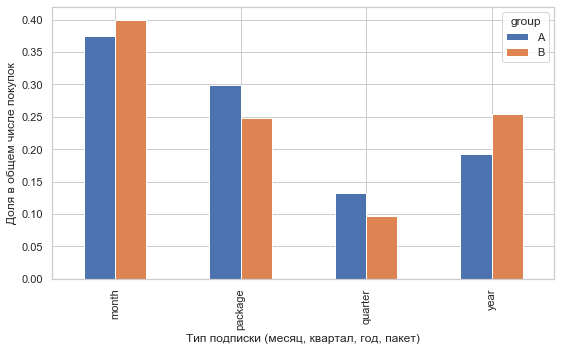

In [17]:
fig, ax = plt.subplots(figsize=(9,5))
__ = purch_struct_df.purchase_share.unstack(level=0).plot(kind='bar', ax = ax)
__ = ax.set_xlabel("Тип подписки (месяц, квартал, год, пакет)")
__ = ax.set_ylabel("Доля в общем числе покупок")


Самые популярные подписки на месяц, а второе место в группе A принадлежит пакетам, а в группе B годовым подпискам (разрыв невелик).  Квартальные подписки — самые непопулярные в обоих группах.

Число покупок — хорошо, но полезно получить ещё долю данного вида подписки в суммарном доходе. Ввожу колонку `grot` — Gross Revenue of Type.

In [18]:
purch_struct_df['grot'] = purch_struct_df.price * purch_struct_df.purchases
purch_struct_df['grot_share'] = None
purch_struct_df.loc['A', 'grot_share'] = purch_struct_df.grot / purch_struct_df.loc['A', 'grot'].sum()
purch_struct_df.loc['B', 'grot_share'] = purch_struct_df.grot / purch_struct_df.loc['B', 'grot'].sum()
epsilon = 1e-14
assert(abs(purch_struct_df.loc['A', 'grot_share'].sum() - 1.0) < epsilon)
assert(abs(purch_struct_df.loc['B', 'grot_share'].sum() - 1.0) < epsilon)

display(purch_struct_df)

price  purchases  purchase_share     grot grot_share
group purch_type                                                      
A     month         350       2282        0.375021   798700   0.248352
      package        50       1824        0.299753    91200  0.0283582
      year         1500       1176        0.193262  1764000   0.548507
      quarter       700        803        0.131964   562100   0.174782
B     month         350       3639        0.399802  1273650   0.232361
      year         1500       2319        0.254779  3478500   0.634606
      package        50       2264        0.248737   113200  0.0206518
      quarter       700        880        0.096682   616000   0.112381

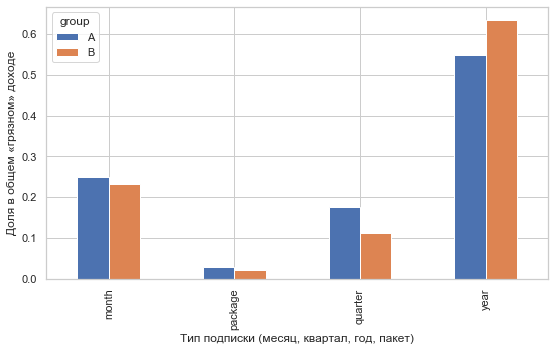

In [19]:
fig, ax = plt.subplots(figsize=(9,5))
__ = purch_struct_df.grot_share.unstack(level=0).plot(kind='bar', ax = ax)
__ = ax.set_xlabel("Тип подписки (месяц, квартал, год, пакет)")
__ = ax.set_ylabel("Доля в общем «грязном» доходе")

На диаграмме видно, что доходы в группах от месячных и пакетных подписок близки, а в подписках на квартал и год имеются значительные расхождения: покупатели из группы B охотнее покупают годовые подписки, чем квартальные.  Учитывая, что на графике относительный показатель — доля в продажах, можно сказать, что в группе B по сравнению с A произошёл переток пользователей с кратковременных тарифных планов на годовой. Особенно это выражено для квартальных и годовых подписок.

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

#### Сводные данные по группам <a name='groups_ue_summary'/>

В таблице ниже V обозначает посетителя (Visitor), U — пользователя (User), С — покупателя (Customer).

 Группа | Посетителей | Пользователей | Покупателей | Конверсия V→U,% | Конверсия V→C, % | AvP, руб. | ARPC, руб. | ARPU, руб.
--------|:------------|:--------------|:------------|:-----------------|:------------------|:-------|:--------|:--------
    A   | 101329 | 31439 | 5815 |       31.03     |  5.74             | 528.51 | 553.05  | 31.74
    B   | 151843 | 41046 | 8797 |       27.03     |  5.79             | 602.21 | 623.09  | 36.10

Любопытно, что более высокая конверсия посетителей группы А в пользователей была «отыграна» при конверсии в клиентов (Customer): сквозная конверсия групп мало отличается. 

| [К оглавлению](#contents) | [К началу раздела](#unit_economy)  |
|:--------------------------|-----------------------------------:|

## Расчёт статистической значимости полученных параметров <a name='statsign'>

Статистическую значимость буду рассчитывать для параметров:

1. [Сквозная конверсия (V→C)](#statsign_conv_vc)
2. [ARPC](#statsign_arpc)

Среди полученных в первой части эта пара параметров наименее зависимы друг от друга. Остальные производные.

### Расчёт статистической значимости для сквозной конверсии.  <a name='statsign_conv_vc'/>

Расчитаю доверительные интервалы для обоих групп и p-value для конверсии группы B, принимая за базовую гипотезу то, что она не отличается от конверсии группы A.  За достаточно малое значение p-value приму 0.05 (то есть вероятность случайного получения такого отклонения должна быть ≤ 1/20), доверительные интервалы буду рассчитывать исходя из вероятности нахождения среднего по популяции в данном интервале в 99%.  При расчёте конверсии (так как это пропорция) принимаем за $Z_{крит}$ 2.576.

Конверсия — это пропорция, для расчёта доверительных интервалов используется формула:

$$
p = \hat{p} \pm Z_{крит} \times \sqrt{ {\hat{p}\,(1-\hat{p})\strut} \over {n} }
$$

То есть выборочное среднее плюс-минус $Z_{крит}$, умноженное на выборочную стандартную ошибку.

In [20]:
Z_CRIT = 2.576  # 99% confidence interval
# Стандартные отклонения
a_sd = sqrt( (conversion_v_c['A'] * (1 - conversion_v_c['A'])) / ab_grps_cnt.loc['A', 'n_cookies'] )
b_sd = sqrt( (conversion_v_c['B'] * (1 - conversion_v_c['B'])) / ab_grps_cnt.loc['B', 'n_cookies'] )
print(f"Стандартные отклонения конверсии: A: {a_sd:f}, B: {b_sd:f}")
print("""Доверительные интервалы 99%: 
A: {0:.2%} ± {1:.3%},
B: {2:.2%} ± {3:.3%}
""".format(
    conversion_v_c['A'], Z_CRIT * a_sd,
    conversion_v_c['B'], Z_CRIT * b_sd
))

Стандартные отклонения конверсии: A: 0.000731, B: 0.000600
Доверительные интервалы 99%: 
A: 5.74% ± 0.188%,
B: 5.79% ± 0.154%



Доверительные интервалы **сильно пересекаются**.  Я бы уже тут признал расхождение
статистически *не*значимым, но если просят расчитать p-value, то тоже не проблема:

Для теста нужно для каждой группы создать массив нулей и единиц, где ноль соответствует посетителю, который 
в конечном итоге не стал покупателем, а единица — покупателю.

In [21]:
abt_ztest_data = abt_cookies_df.merge(reg_df, how='left', on='cookie_id').merge(purch_df, how='left', on='user_id').set_index('grp')
# Небольшой хак: мы знаем, что int(False) = 0 и int(True) = 1
abt_ztest_a = (abt_ztest_data.loc['A'].groupby('cookie_id').min()['purchase_id'].notnull().astype(int))
abt_ztest_b = (abt_ztest_data.loc['B'].groupby('cookie_id').min()['purchase_id'].notnull().astype(int))
print(f"Группа A: {abt_ztest_a.sum()} покупателей из {len(abt_ztest_a)} посетителей.")
print(f"Группа B: {abt_ztest_b.sum()} покупателей из {len(abt_ztest_b)} посетителей.")
zscore, pvalue = ztest(abt_ztest_a, abt_ztest_b)
print(f"Результаты Z-теста: Z-score: {zscore:.3f}, p-value: {pvalue:.3f}")

Группа A: 5815 покупателей из 101329 посетителей.
Группа B: 8797 покупателей из 151843 посетителей.
Результаты Z-теста: Z-score: -0.579, p-value: 0.563


Результаты Z теста подтверждают, что статистически значимой разницы сквозных конверсий не обнаружено.

#### Вывод по расчёту значимости конверсии: 

значимых расхождений между группами не обнаружено.

| [К оглавлению](#contents) | [К началу раздела](#statsign)  |
|:--------------------------|-------------------------------:|

### Расчёт статистической значимости для ARPC <a name='statsign_arpc'/>

ARPC — числовой параметр (не пропорция), поэтому для получения доверительного интервала в общем случае используется распределение Стьюдента.  Но у нас большая выборка (более 5800 клиентов в меньшей из групп), это позволяет нам пользоваться распределением Гаусса. Как и для конверсии, будем использовать 99% доверительный интервал, $Z_{крит}$ в этом случае 2.576 (Распределение Стьюдента даёт 2.577, можно пренебречь разницей в 4 знаке).

#### Расчёт доверительных интервалов

Замечу, что сам средний чек распределён не нормально: количество покупок на клиента незначительно превышает 1, поэтому параметр ARPC будет группироваться по цене подписки: будут группы, соответствующие ценам 350, 700, 1500, 50 руб. Но нас в расчёте статистической значимости интересует распределение выборочного среднего и популяционного среднего, по ЦПТ это распределение будет стремиться к нормальному.

Формулы для расчёта:

\begin{equation}
\mu \in \bar{x} \pm Z_{крит} \times Se
\end{equation}
Где $Se$ — выборочная стандартная ошибка: 

$$
Se = \frac{s}{\sqrt{n}}.
$$

Где, в свою очередь, $n$ — число измерений и $s$ — среднеквадратическое отклонение на выборке,
рассчитываемое по формуле:

$$
s =  \sqrt{ \frac{\sum_{i=1}^{n}{(x_i - \bar{x})^2}}{n-1} }
$$

Вооружившись этими формулами, можно рассчитать доверительные интервалы.  Но удобнее воспользоваться библиотечной функцией.

In [22]:
pre_amounts_1 = abt_ztest_data.loc[abt_ztest_data.purchase_id.notnull(),['user_id','amount']]
amounts = pre_amounts_1.groupby(['grp', 'user_id'],as_index=True).sum()
a_amounts = amounts.loc['A','amount']
b_amounts = amounts.loc['B','amount']
a_arpc_mean, b_arpc_mean = (a_amounts.mean(), b_amounts.mean())
a_arpc_se, b_arpc_se = (spstats.sem(a_amounts), spstats.sem(b_amounts) )
print("""Статистические параметры распределений среднего дохода на пользователя:
Группа А:
  Среднее (ARPC): {0:.02f}
  Стандартное отклонение (s): {1:.02f}
  Выборочная стандартная ошибка распределения ARPC (Se): {2:.03f}
Группа B:
  Среднее: (ARPC) {3:.02f}
  Стандартное отклонение (s): {4:.02f}
  Выборочная стандартная ошибка ARPC (Se): {5:.03f}
""".format(
    a_arpc_mean, a_amounts.std(), a_arpc_se, # {0}-{2}
    b_arpc_mean, b_amounts.std(), b_arpc_se, # {3}-{5}
))
del(pre_amounts_1)
del(amounts)
# del(a_amounts)
# del(b_amounts)

Статистические параметры распределений среднего дохода на пользователя:
Группа А:
  Среднее (ARPC): 553.05
  Стандартное отклонение (s): 515.76
  Выборочная стандартная ошибка распределения ARPC (Se): 6.764
Группа B:
  Среднее: (ARPC) 623.09
  Стандартное отклонение (s): 552.68
  Выборочная стандартная ошибка ARPC (Se): 5.893



Обратите внимание, как из выборки с довольно большим стандартным отклонением $s$ получается распределение среднего с небольшим $Se$

Зная стандартную ошибку распредения среднего платежа в группах, легко получить доверительные интервалы для ARPC: <a name='confidence_intervals_arpc'/>

In [25]:
a_arpc_t = (a_arpc_mean - Z_CRIT * a_arpc_se, a_arpc_mean + Z_CRIT * a_arpc_se)
b_arpc_t = (b_arpc_mean - Z_CRIT * b_arpc_se, b_arpc_mean + Z_CRIT * b_arpc_se)
print(f"""Доверительные интервалы (99%) для ARPC:
Группа А: от {a_arpc_t[0]:.2f} до {a_arpc_t[1]:.2f},
Группа B: от {b_arpc_t[0]:.2f} до {b_arpc_t[1]:.2f}
""")
# .format(a_arpc_t, b_arpc_t))

Доверительные интервалы (99%) для ARPC:
Группа А: от 535.63 до 570.48,
Группа B: от 607.91 до 638.27



Как видим, доверительные интервалы не пересекаются, что позволяет говорить о статистической значимости различия между ARPC в группах A и B.  Проверим себя двумя различными тестами статистической значимости (p-value).  Напомню, что p-value — это вероятность того, что при случайной выборке из генеральной совокупности с распределением, как в группе A, получится выборка со средним B.

Выбраны тесты Mann-Whitney и Kruskal-Wallis.  [Начальные условия тестов](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/) (обе группы распределены похоже и значения могут быть ранжированы) выполнены.

In [24]:
print("p-value по тесту Mann-Whitney: {:.3e}".format(spstats.mannwhitneyu(a_amounts, b_amounts)[1]))
print("p-value по тесту Kruskal-Wallis: {:.3e}".format(spstats.kruskal(a_amounts, b_amounts)[1]))

p-value по тесту Mann-Whitney: 1.589e-11
p-value по тесту Kruskal-Wallis: 3.179e-11


Оба теста дают очень маленькие p-value, что наряду с разницей в доверительных интервалах говорит о
статистической значимости различий между группами в среднем доходе с клиента.

| [К оглавлению](#contents) | [К началу раздела](#statsign)  |
|:--------------------------|-------------------------------:|

## Выводы по эксперименту <a name='closure'/>

1. Поскольку предлагается не провести эксперимент, а *анатомировать* его результаты, то выводы с точки зрения бизнеса сделать затруднительно.

2. Статистически значимых отличий в «Сквозной» конверсии из посетителей в клиентов между группами А и Б выявить не удалось.

3. Выявлена [существенная и статистически значимая разница](confidence_intervals_arpc) в параметре ARPC (средний доход с клиента): в группе B этот параметр выше, чем в группе A.

4. Предполагаю, что более высокий показатель ARPC в группе B  вызван повышением доли годовых подписок и снижением доли квартальных.  В этом случае общий доход с пользователей группы B на длинных интервалах _снизится_ по сравнению с группой А.  С другой стороны, пользователи с длинными контрактами более предсказуемы.

| [К оглавлению](#contents) |
|---------------------------|